In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-04-14 23:27:03--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.26
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.26|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-04-14 23:27:04--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1594 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.56K  --.-KB/s    in 0s      

2021-04-14 23:27:04 (33.8 MB/s) - written to stdout [1594/1594]

setup Colab 

In [2]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [40]:
from google.colab import files
uploaded = files.upload()

Saving covidvaccine.csv to covidvaccine.csv


In [4]:
df=pd.read_csv('covid19_tweets.csv')

In [6]:
df

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False


In [7]:
spark = sparknlp.start()

In [8]:
text_list=df['text'].to_list()

In [9]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = ClassifierDLModel.pretrained(name='classifierdl_use_emotion')\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]


In [10]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({"text":text_list}))
result = pipelineModel.transform(df)

In [11]:

result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+---------+
|document                                                                                                                                     |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------+---------+
|If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0 |surprise |
|Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu |sadness  |
|@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3 |fear     |
|@brookbanktv The one gift #COVID19 has give me is an appreciation for the s

In [12]:
result.select('sentiment.result').show(truncate=False)

+----------+
|result    |
+----------+
|[surprise]|
|[sadness] |
|[fear]    |
|[joy]     |
|[fear]    |
|[fear]    |
|[fear]    |
|[joy]     |
|[joy]     |
|[joy]     |
|[sadness] |
|[joy]     |
|[fear]    |
|[fear]    |
|[joy]     |
|[joy]     |
|[surprise]|
|[joy]     |
|[fear]    |
|[fear]    |
+----------+
only showing top 20 rows



In [13]:
result_df=result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).toPandas()

In [14]:
result_df

,document,sentiment
0,If I smelled the scent of hand sanitizers toda...,surprise
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,sadness
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,fear
3,@brookbanktv The one gift #COVID19 has give me...,joy
4,25 July : Media Bulletin on Novel #CoronaVirus...,fear
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,surprise
179104,2020! The year of insanity! Lol! #COVID19 http...,fear
179105,@CTVNews A powerful painting by Juan Lucena. I...,joy
179106,"More than 1,200 students test positive for #CO...",surprise


In [15]:
df_ori=pd.read_csv('covid19_tweets.csv')

In [16]:
df_ori

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False


In [17]:
result_df.rename(columns = {'document' : 'text', 'sentiment' : 'sentiment'}, inplace = True)

In [18]:
df_clean=pd.merge(df_ori, result_df, on="text")

In [19]:
import matplotlib.pyplot as plt
import altair as alt
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean['date'] = df_clean['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [20]:
df_clean

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,surprise
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,sadness
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,fear
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,joy
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181135,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False,surprise
181136,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False,fear
181137,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False,joy
181138,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False,surprise


Text(0, 0.5, 'frequency')

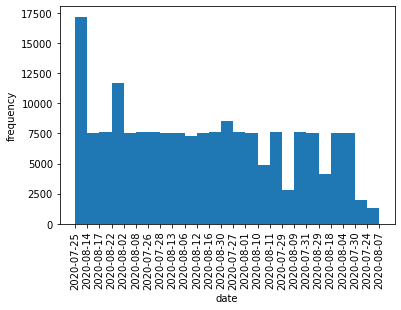

In [21]:

plt.hist(df_clean['date'],bins=25)
plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.xlabel('date')
plt.ylabel('frequency')

In [22]:
sentiment_count=df_clean.groupby(['sentiment']).size().reset_index(name='count')

In [23]:
alt.Chart(sentiment_count).mark_bar().encode(
    x='count',
    y='sentiment'
)

alt.Chart(...)

In [24]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [25]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

df_pn = spark.createDataFrame(pd.DataFrame({"text":text_list}))
result_pn = pipelineModel.transform(df_pn)

In [26]:

result_pn.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).show(truncate=False)
result_df_pn=result_pn.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).toPandas()

+---------------------------------------------------------------------------------------------------------------------------------------------+---------+
|document                                                                                                                                     |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------+---------+
|If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0 |negative |
|Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu |neutral  |
|@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3 |positive |
|@brookbanktv The one gift #COVID19 has give me is an appreciation for the s

In [27]:
result_df_pn.rename(columns = {'document' : 'text', 'sentiment' : 'sentiment_positive_negative'}, inplace = True)
df_clean=pd.merge(df_clean, result_df_pn, on="text")

In [28]:
df_clean

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sentiment,sentiment_positive_negative
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,surprise,negative
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,sadness,neutral
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,fear,positive
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,joy,positive
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,fear,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194619,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False,surprise,positive
194620,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False,fear,positive
194621,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False,joy,negative
194622,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False,surprise,negative


In [29]:
pnn_count=df_clean.groupby(['sentiment_positive_negative']).size().reset_index(name='count_pnn')

In [30]:
alt.Chart(pnn_count).mark_bar().encode(
    x='count_pnn',
    y='sentiment_positive_negative'
)

alt.Chart(...)

In [31]:
from wordcloud import WordCloud, STOPWORDS

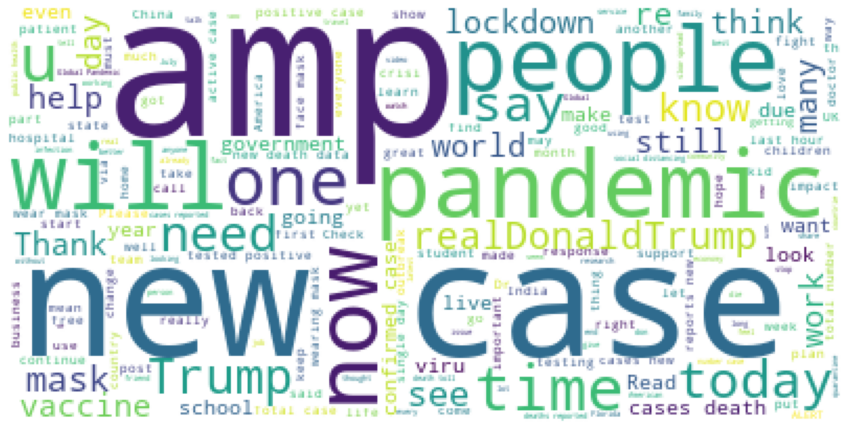

In [32]:
text_string=" ".join(str(x) for x in text_list)
stopwords=set(STOPWORDS)
stopwords.update(['https','COVID19','COVID','coronavirus','CO'])
wordcloud=WordCloud(stopwords=stopwords,background_color='white').generate(text_string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [33]:
geo=df_clean.groupby(['user_location']).size().reset_index(name='count_location')

In [34]:
geo=geo.sort_values('count_location', ascending=False)[:30]

In [35]:
geo

,user_location,count_location
10082,India,3806
22680,United States,2485
15122,"New Delhi, India",1882
22281,UK,1799
12523,"London, England",1458
14369,"Mumbai, India",1404
23510,"Washington, DC",1363
22652,United Kingdom,1206
24344,Worldwide,1149
12362,London,1109


In [36]:
alt.Chart(geo).mark_bar().encode(
    alt.X('count_location'),
    alt.Y('user_location',sort=alt.EncodingSortField(field="count_location", order='descending'))
)

alt.Chart(...)

In [37]:
tweets_number=df_clean.groupby(['date']).size().reset_index(name='count')

In [38]:
alt.Chart(tweets_number).mark_line().encode(
    x=alt.X('date'),
    y='count'
)

alt.Chart(...)

In [39]:
number_of_tweet=df_clean.groupby(['user_name']).size().reset_index(name='count of tweets')
number_of_tweet=number_of_tweet.sort_values('count of tweets', ascending=False)[:30]
dict_user=df_clean.set_index('user_name')['user_followers'].to_dict()
number_of_tweet['user_followers'] = number_of_tweet['user_name'].map(dict_user)
alt.Chart(number_of_tweet).mark_circle().encode(
    x='count of tweets',
    y='user_followers',
    tooltip=['user_name']
).interactive()

alt.Chart(...)